## Análisis no supervisado
### 1. Importación de librerías

In [36]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from matplotlib.lines import Line2D
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

### 2. Carga del dataset original

In [7]:
df = pd.read_csv("../dataset/steam_dataset.csv")
df.shape

(1932, 25)

### 3. Selección de videojuegos y variables relevantes
Se seleccionarán variables útiles para realizar un análisis no supervisado con el objetivo de detectar patrones y tipologías de videojuegos a partir de sus características técnicas y funcionales. A partir de estas agrupaciones, se podrá analizar si determinados perfiles se asocian con una mayor valoración por parte de los usuarios.
#### 3.1 Filtrado solo a videojuegos

In [8]:
df_games = df[df["app_type"] == "Game"].copy()
df_games.shape

(1814, 25)

#### 3.2 Selección de variables para análisis no supervisado

Se han seleccionado variables que describen características funcionales y tecnológicas de los juegos dentro del ecosistema Steam, evitando métricas de popularidad o rendimiento comercial. El objetivo es identificar tipologías de juego basadas en su perfil de plataformas, conectividad y servicios asociados, más que en su éxito relativo.

En concreto, se han incluido variables relacionadas con la disponibilidad multiplataforma, modalidades multijugador, integracion con servicios de Steam (Workshop, Trading cards, estadísticas...) y compatibilidad con funcionalidades avanzadas como cloud gaming o juego remoto. Estas características reflejan el grado de complejidad técnica y el modelo de experiencia ofrecida al usuario.

La fecha de lanzamiento se ha incoporado como variable temporal para capturar posibles patrones asociados a la evolución tecnológica del catálogo, mientras que variables administrativas o de sistema se han excluido al no aportar información relevante sobre la tipología del producto. 

In [9]:
features_unsup = [
    "platforms",
    "multiplayer",
    "cross_platform_multiplayer",
    "steam_workshop",
    "steam_trading_cards",
    "in_app_purchases",
    "valve_anti_cheat",
    "cloud_gaming",
    "stats",
    "remote_play_on_phone",
    "remote_play_on_tablet",
    "release_date",
    "sys_date"
]

df_unsup = df_games[features_unsup].copy()

### 4. Limpieza y transformación de variables
#### 4.1 Limpieza de la variable platforms
Se eliminan los valores nulos, y se codifica la variable original de manera sencilla y unificando los distintos nombres posibles, que se refieren a la misma plataforma.

In [10]:
df_unsup.dropna(subset=["platforms"], inplace=True)

platform_mapping = {
    "Windows": 1,
    "Windows macOS": 2,
    "macOS Windows": 2,
    "Windows Linux": 3,
    "Windows macOS Linux": 4,
    "macOS Windows Linux": 4
}

df_unsup["platform"] = df_unsup["platforms"].map(platform_mapping)
df_unsup.drop(columns=["platforms"], inplace=True)

#### 4.2 Procesamiento de fechas y antiguedad del juego
Se modifica el formato de la fecha del videojuego para calcular la antiguedad como meses desde que se publicó el videojuego.

In [11]:
# Limpieza del formato de release_date
df_unsup["release_date"] = (
    df_unsup["release_date"]
    .str.replace(r"\s*–\s*", " ", regex=True)
    .str.replace(r" UTC \( \)", "", regex=True)
    .str.strip()
)

df_unsup["release_date"] = pd.to_datetime(
    df_unsup["release_date"],
    format="%d %B %Y %H:%M:%S",
    errors="coerce"
)

# Parseo seguro de sys_date
def parse_date_safe(x):
    try:
        return pd.to_datetime(x, format="%Y-%m-%dT%H:%M:%S.%f")
    except:
        return pd.to_datetime(x, format="%Y-%m-%d %H:%M:%S.%f")

df_unsup["sys_date"] = df_unsup["sys_date"].apply(parse_date_safe)

# Cálculo de meses desde lanzamiento
df_unsup["months_since_release"] = (
    (df_unsup["sys_date"] - df_unsup["release_date"]).dt.days / 30
)

# Acotamos valores extremos
df_unsup["months_since_release"] = df_unsup["months_since_release"].clip(lower=1, upper=60)

df_unsup.drop(columns=["release_date", "sys_date"], inplace=True)

4.3 Eliminacion de filas con nulos

In [12]:
df_unsup.dropna(inplace=True)
df_unsup.shape

(1769, 12)

### 5. Escalado de variables

Dado que las variables seleccionadas presentan diferentes escalas y rangos de valores se deben estandarizar todas ellas para que todas tengan media cero y desviación estándar uno, evitando que aquellas con mayor rango o varianza numérica dominen el cálculo de distancias en los análisis posteriores. 

In [13]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(df_unsup)

Una vez estandarizados los datos, se lleva a cabo un Análisis de Componentes Principales (PCA) con el objetivo de reducir la dimensionalidad del conjunto de variables y así visualizar la estructura subyacente de los datos. 

Se extrajeron las 3 primeras componentes principales, así como la varianza total acumulada y la varianza explicada por cada componente. 

In [14]:
pca = PCA(n_components=3, random_state=42)
X_pca = pca.fit_transform(X_scaled)
print("Varianza explicada por componente:", pca.explained_variance_ratio_)
print("Varianza total explicada:", pca.explained_variance_ratio_.sum())

Varianza explicada por componente: [0.18692003 0.13637505 0.13245443]
Varianza total explicada: 0.4557495101177591


Este análisis muestra que las tres primeras componentes concentran aproximadamente el 45,6% de la varianza total. Ningún componente domina claramente la varianza, lo que sugiere la ausencia de un único eje estructural que explique por sí solo las diferencias entre juegos, ya que el conjunto de datos analizado es bastante complejo.

#### 6.2 Visualización PCA

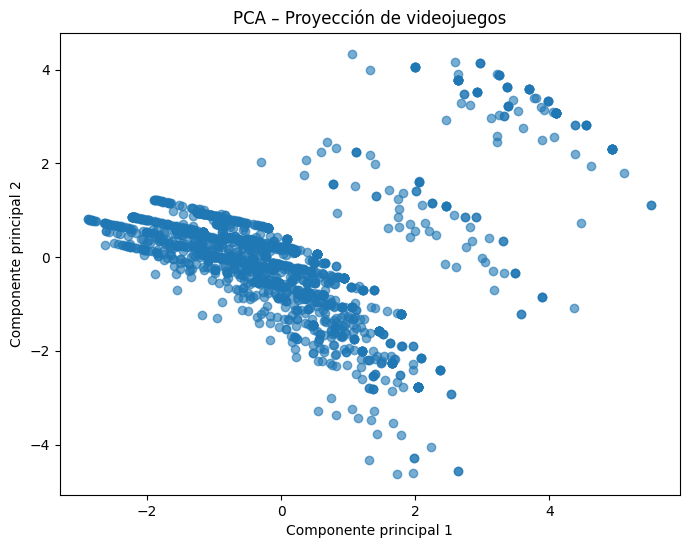

In [15]:
plt.figure(figsize=(8,6))
plt.scatter(X_pca[:, 0], X_pca[:, 1], alpha=0.6)
plt.xlabel("Componente principal 1")
plt.ylabel("Componente principal 2")
plt.title("PCA – Proyección de videojuegos")
plt.show()

Este PCA sugiere la existencia de tres clústers diferenciados. Sin embargo, hay que probar distintas combinaciones de clústers para decidir si esta apariencia tiene un sustento estadístico claro detrás.


### 7. Elección del número de clústers

En primer lugar, se aplica el método del codo sobre el algoritmo K-Means, evaluando valores de k entre 2 y 20 clústers. Se basa en la inercia, definida como la suma de distancias cuadráticas de cada observación a su centroide asignado, y porporciona una medida de la idoneidad de los clústers asignados.

El criterio del codo consiste en identificar un punto a partit del cual el descenso de la inercia se ralentiza notablemente, indicando que añadir más clústers aporta mejoras marginales.

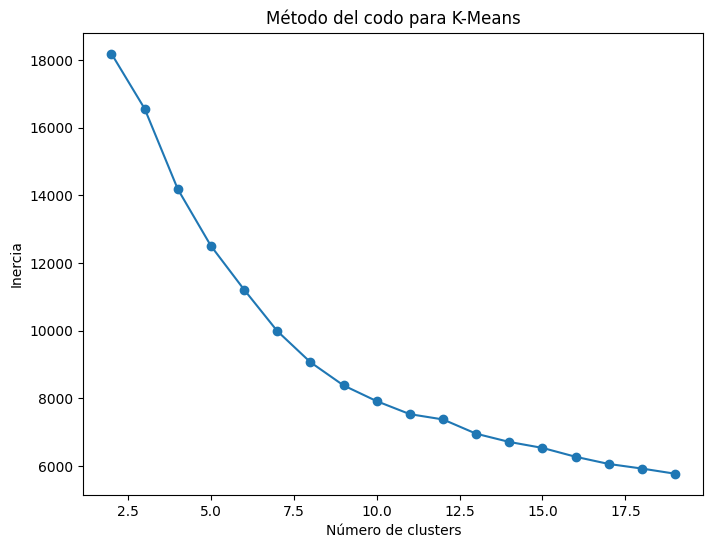

In [21]:
inertia = []
K = range(2, 20)
# 
for k in K:
    km = KMeans(n_clusters=k, random_state=42, n_init=10)
    km.fit(X_scaled)
    inertia.append(km.inertia_)

plt.figure(figsize=(8,6))
plt.plot(K, inertia, marker="o")
plt.xlabel("Número de clusters")
plt.ylabel("Inercia")
plt.title("Método del codo para K-Means")
plt.show()

Inicialmente, se ha evaluado el número óptimo de clústers mediante el método del codo aplicado a la inercia de K-Means. Este análisis sugiere un punto de inflexión alrededor de k = 10, lo que podría indicar la existencia de múltiples grupos. Sin embargo, considerando la estructura relativamente continua de los datos y el elevado número de clústers, se sospecha un riesgo de sobreajuste, ya que valores altos de k tienden a producir clústers muy pequeños y dominados por una sola variable. Para abordar esta limitación, se repitió el análisis utilizando el índice de silhouette como criterio de calidad de los clústers. La silhouette mide la cohesión interna y la separación entre clústers, tomando valores entre −1 y 1, donde valores altos indican observaciones bien asignadas y grupos bien diferenciados.

k=2, silhouette=0.327


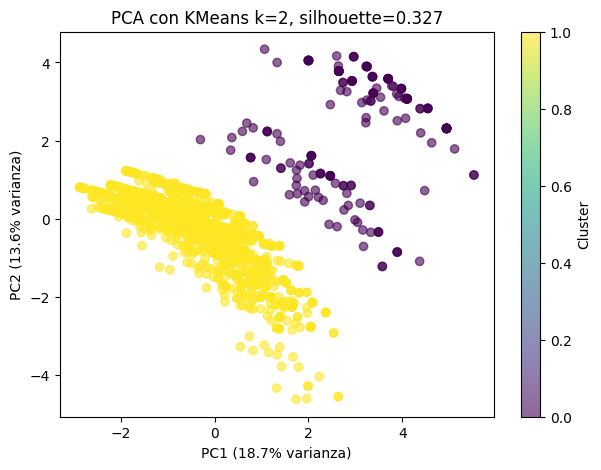

Medias de variables por cluster para k=2:


,multiplayer,cross_platform_multiplayer,steam_workshop,steam_trading_cards,in_app_purchases,valve_anti_cheat,cloud_gaming,stats,remote_play_on_phone,remote_play_on_tablet,platform,months_since_release
cluster,,,,,,,,,,,,
0,-0.346375,-0.210063,-0.066216,0.339713,-0.220105,-0.065436,0.079698,-0.040417,2.370734,2.869028,0.340924,0.918458
1,0.039237,0.023796,0.007501,-0.038482,0.024933,0.007413,-0.009028,0.004578,-0.268554,-0.325000,-0.038619,-0.104042


k=3, silhouette=0.149


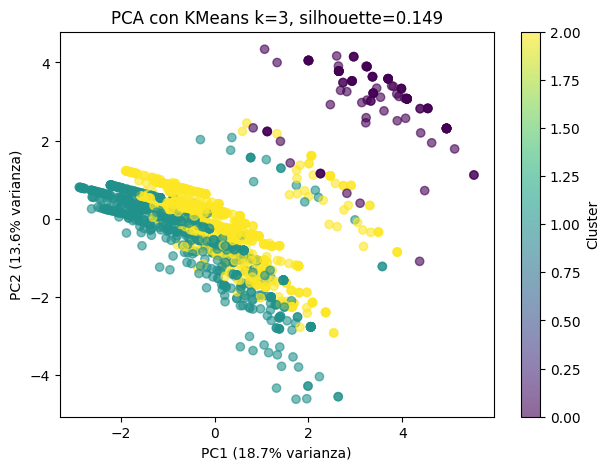

Medias de variables por cluster para k=3:


,multiplayer,cross_platform_multiplayer,steam_workshop,steam_trading_cards,in_app_purchases,valve_anti_cheat,cloud_gaming,stats,remote_play_on_phone,remote_play_on_tablet,platform,months_since_release
cluster,,,,,,,,,,,,
0,-0.299251,-0.244648,-0.328244,0.280826,-0.230011,-0.025098,-0.007247,-0.025709,3.723647,2.762460,0.275521,0.933114
1,0.816195,0.442132,-0.008690,-0.022254,0.508242,0.169412,0.340030,-0.039601,-0.268554,-0.249697,-0.043995,0.049804
2,-0.670325,-0.351978,0.051854,-0.018512,-0.411518,-0.144129,-0.295103,0.037951,-0.268554,-0.155290,0.001135,-0.169263


k=4, silhouette=0.211


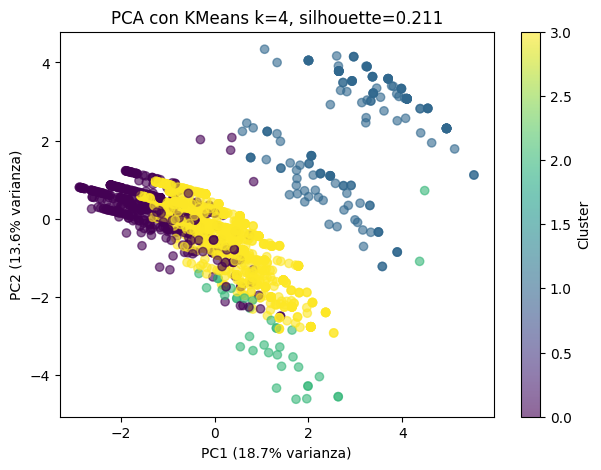

Medias de variables por cluster para k=4:


,multiplayer,cross_platform_multiplayer,steam_workshop,steam_trading_cards,in_app_purchases,valve_anti_cheat,cloud_gaming,stats,remote_play_on_phone,remote_play_on_tablet,platform,months_since_release
cluster,,,,,,,,,,,,
0,0.568990,0.894774,-0.295208,-0.321008,1.447328,-0.144129,-0.303243,-0.019281,-0.268554,-0.295482,-0.158013,-0.130991
1,-0.386920,-0.278574,-0.068807,0.356136,-0.260754,-0.144129,0.080082,-0.061135,2.415857,2.861859,0.346109,0.915941
2,0.829444,0.268897,0.835411,0.260339,-0.066347,6.938219,0.235619,0.299176,-0.046765,-0.136004,0.786851,0.946850
3,-0.204773,-0.340345,0.107458,0.069804,-0.564170,-0.144129,0.106902,0.007974,-0.268554,-0.325000,-0.014304,-0.121196


k=5, silhouette=0.214


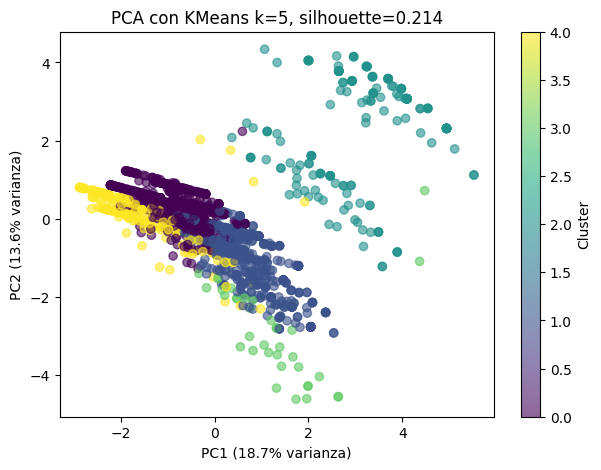

Medias de variables por cluster para k=5:


,multiplayer,cross_platform_multiplayer,steam_workshop,steam_trading_cards,in_app_purchases,valve_anti_cheat,cloud_gaming,stats,remote_play_on_phone,remote_play_on_tablet,platform,months_since_release
cluster,,,,,,,,,,,,
0,-0.153183,-0.351978,-0.335348,-0.713143,0.033618,-0.144129,-0.284235,-0.044035,-0.268554,-0.320677,-0.327504,-0.523924
1,0.011290,-0.330403,0.508469,0.962142,-0.274994,-0.144129,0.430896,0.094432,-0.268554,-0.325000,0.275163,0.413391
2,-0.382188,-0.296606,-0.066650,0.351118,-0.245583,-0.144129,0.085943,-0.060198,2.431374,2.860616,0.329924,0.929759
3,0.829444,0.268897,0.835411,0.260339,-0.066347,6.938219,0.235619,0.299176,-0.046765,-0.136004,0.786851,0.946850
4,0.829444,2.841090,-0.307397,-0.433480,1.001179,-0.144129,-0.302474,-0.119362,-0.268554,-0.249819,0.052186,-0.151019


k=6, silhouette=0.225


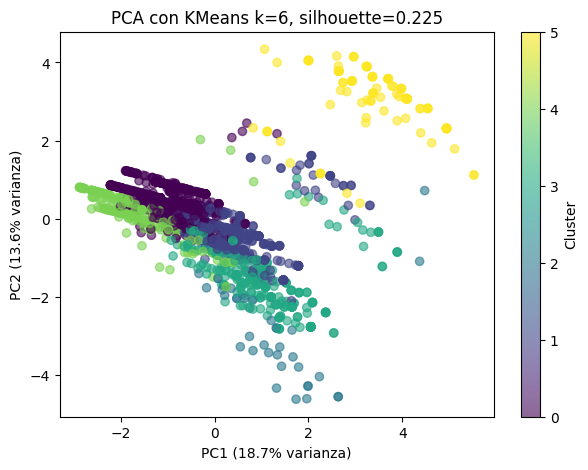

Medias de variables por cluster para k=6:


,multiplayer,cross_platform_multiplayer,steam_workshop,steam_trading_cards,in_app_purchases,valve_anti_cheat,cloud_gaming,stats,remote_play_on_phone,remote_play_on_tablet,platform,months_since_release
cluster,,,,,,,,,,,,
0,-0.134076,-0.351978,-0.430252,-0.734888,0.092852,-0.144129,-0.381561,-0.047875,-0.268554,-0.305477,-0.307359,-0.612598
1,-0.090982,-0.351978,-0.441894,0.919281,-0.219999,-0.144129,0.513586,0.010853,-0.268554,-0.092088,0.022734,0.426513
2,0.829444,0.268897,0.835411,0.260339,-0.066347,6.938219,0.235619,0.299176,-0.046765,-0.136004,0.786851,0.946850
3,-0.011300,-0.265678,2.262986,0.404596,-0.427490,-0.144129,0.265934,0.176128,-0.268554,-0.062303,0.551515,0.414345
4,0.829444,2.841090,-0.350718,-0.438484,1.027809,-0.144129,-0.314358,-0.117611,-0.268554,-0.248552,0.015772,-0.163245
5,-0.318545,-0.270104,-0.349419,0.282145,-0.243760,-0.144129,-0.025677,-0.062521,3.723647,2.757084,0.250383,0.932117


k=7, silhouette=0.238


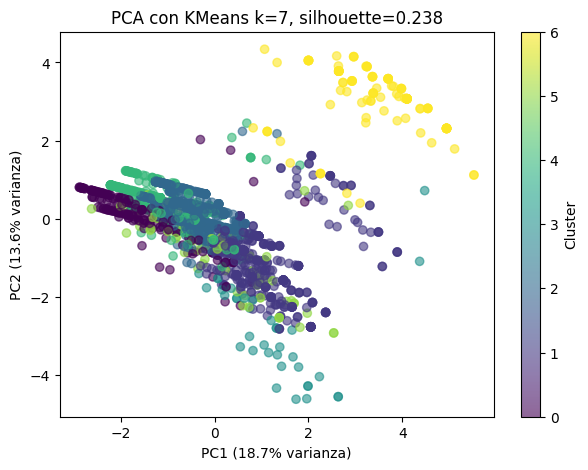

Medias de variables por cluster para k=7:


,multiplayer,cross_platform_multiplayer,steam_workshop,steam_trading_cards,in_app_purchases,valve_anti_cheat,cloud_gaming,stats,remote_play_on_phone,remote_play_on_tablet,platform,months_since_release
cluster,,,,,,,,,,,,
0,0.829444,2.841090,-0.318945,-0.445781,0.993650,-0.144129,-0.295929,-0.223275,-0.268554,-0.247684,0.043836,-0.161614
1,0.015415,-0.317270,0.781182,0.829269,-0.523721,-0.144129,0.421561,-0.223275,-0.268554,0.015192,0.540892,0.645133
2,-0.382667,-0.351978,-0.348622,-0.458578,-0.578873,-0.144129,-0.110542,-0.223275,-0.268554,-0.314336,-0.344383,-0.595710
3,0.829444,0.268897,0.835411,0.260339,-0.066347,6.938219,0.235619,0.299176,-0.046765,-0.136004,0.786851,0.946850
4,0.385707,-0.351978,-0.360544,-0.272090,1.727494,-0.144129,-0.300725,-0.223275,-0.268554,-0.235476,-0.324067,-0.114110
5,-0.054205,-0.183921,0.341098,0.257355,0.088759,-0.144129,0.042183,4.478786,-0.268554,-0.235476,-0.108277,-0.013755
6,-0.318545,-0.270104,-0.349419,0.282145,-0.243760,-0.144129,-0.025677,-0.062521,3.723647,2.757084,0.250383,0.932117


k=8, silhouette=0.243


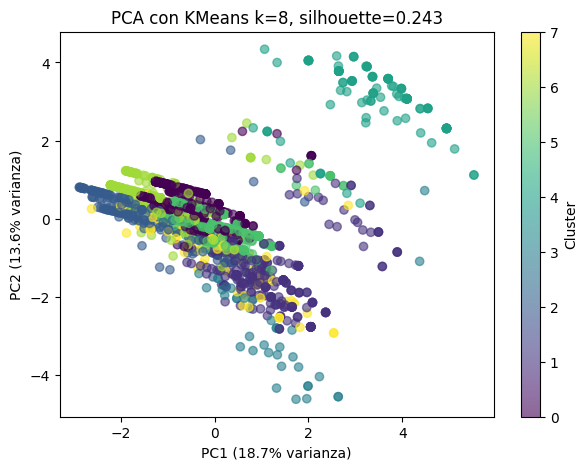

Medias de variables por cluster para k=8:


,multiplayer,cross_platform_multiplayer,steam_workshop,steam_trading_cards,in_app_purchases,valve_anti_cheat,cloud_gaming,stats,remote_play_on_phone,remote_play_on_tablet,platform,months_since_release
cluster,,,,,,,,,,,,
0,-0.431925,-0.351978,-0.354640,-0.313673,-0.578873,-0.144129,-0.933787,-0.223275,-0.268554,-0.270130,-0.249590,-0.396138
1,0.010991,-0.270994,1.674969,0.595584,-0.503666,-0.144129,0.409940,-0.223275,-0.268554,0.007797,1.039347,0.583311
2,0.829444,2.841090,-0.348622,-0.441516,1.011725,-0.144129,-0.311640,-0.223275,-0.268554,-0.246795,0.018906,-0.167677
3,0.829444,0.268897,0.835411,0.260339,-0.066347,6.938219,0.235619,0.299176,-0.046765,-0.136004,0.786851,0.946850
4,-0.318545,-0.270104,-0.349419,0.282145,-0.243760,-0.144129,-0.025677,-0.062521,3.723647,2.757084,0.250383,0.932117
5,-0.130396,-0.351978,-0.427951,0.145779,-0.578873,-0.144129,1.070908,-0.223275,-0.268554,-0.211018,-0.380352,-0.189749
6,0.381424,-0.351978,-0.361151,-0.260924,1.727494,-0.144129,-0.290489,-0.223275,-0.268554,-0.223450,-0.312100,-0.105860
7,-0.054205,-0.183921,0.341098,0.257355,0.088759,-0.144129,0.042183,4.478786,-0.268554,-0.235476,-0.108277,-0.013755


k=9, silhouette=0.242


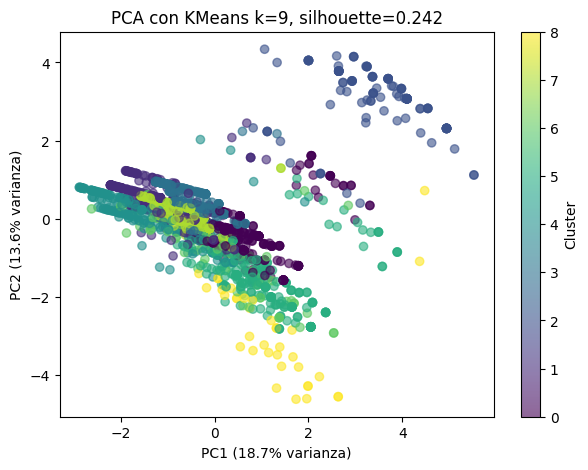

Medias de variables por cluster para k=9:


,multiplayer,cross_platform_multiplayer,steam_workshop,steam_trading_cards,in_app_purchases,valve_anti_cheat,cloud_gaming,stats,remote_play_on_phone,remote_play_on_tablet,platform,months_since_release
cluster,,,,,,,,,,,,
0,-0.216444,-0.351978,-0.441894,1.186254,-0.550312,-0.144129,0.512325,-0.223275,-0.268554,-0.061693,0.120722,0.338195
1,0.396121,-0.351978,-0.369901,-0.289157,1.727494,-0.144129,-0.308749,-0.223275,-0.268554,-0.247390,-0.324614,-0.126721
2,-0.318545,-0.270104,-0.349419,0.282145,-0.243760,-0.144129,-0.025677,-0.062521,3.723647,2.757084,0.250383,0.932117
3,-1.205627,-0.351978,-0.389541,-0.652281,-0.578873,-0.144129,-0.358245,-0.223275,-0.268554,-0.303052,-0.298193,-0.599245
4,0.829444,2.841090,-0.378990,-0.437151,1.030220,-0.144129,-0.304406,-0.223275,-0.268554,-0.245886,-0.006604,-0.181156
5,0.029634,-0.226486,2.262986,0.422009,-0.478159,-0.144129,0.291791,-0.223275,-0.268554,-0.027889,0.672165,0.447550
6,-0.054205,-0.183921,0.341098,0.257355,0.088759,-0.144129,0.042183,4.478786,-0.268554,-0.235476,-0.108277,-0.013755
7,0.829444,-0.351978,-0.441894,-0.774884,-0.578873,-0.144129,0.014937,-0.223275,-0.268554,-0.297001,-0.260750,-0.426224
8,0.829444,0.268897,0.835411,0.260339,-0.066347,6.938219,0.235619,0.299176,-0.046765,-0.136004,0.786851,0.946850


k=10, silhouette=0.250


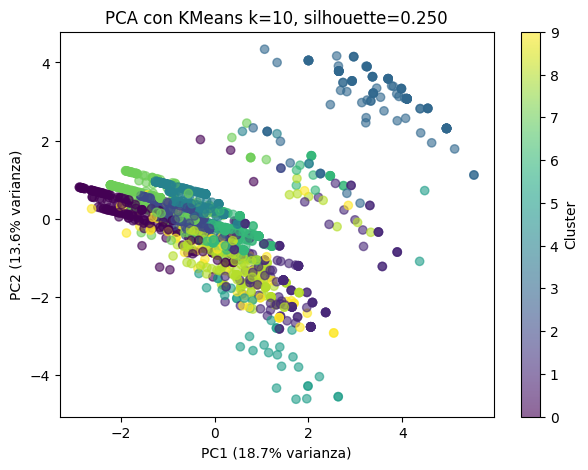

Medias de variables por cluster para k=10:


,multiplayer,cross_platform_multiplayer,steam_workshop,steam_trading_cards,in_app_purchases,valve_anti_cheat,cloud_gaming,stats,remote_play_on_phone,remote_play_on_tablet,platform,months_since_release
cluster,,,,,,,,,,,,
0,0.829444,2.841090,-0.378250,-0.456696,1.049150,-0.144129,-0.308794,-0.223275,-0.268554,-0.264966,-0.032715,-0.194951
1,0.024614,-0.171578,0.933469,0.751383,-0.448570,-0.144129,0.278091,-0.223275,-0.268554,0.059398,2.165321,0.737486
2,0.829444,-0.351978,-0.441894,-0.808007,-0.578873,-0.144129,0.033697,-0.223275,-0.268554,-0.295418,-0.351863,-0.454566
3,-0.318545,-0.270104,-0.349419,0.282145,-0.243760,-0.144129,-0.025677,-0.062521,3.723647,2.757084,0.250383,0.932117
4,-1.205627,-0.351978,-0.441894,-0.653051,-0.578873,-0.144129,-0.323662,-0.223275,-0.268554,-0.279489,-0.337504,-0.610645
5,0.829444,0.268897,0.835411,0.260339,-0.066347,6.938219,0.235619,0.299176,-0.046765,-0.136004,0.786851,0.946850
6,-0.103882,-0.351978,-0.441894,1.224168,-0.324378,-0.144129,0.524802,-0.223275,-0.268554,-0.137308,-0.410213,0.280365
7,0.359116,-0.351978,-0.405829,-0.508456,1.727494,-0.144129,-0.470479,-0.223275,-0.268554,-0.234282,-0.367373,-0.275242
8,-0.099313,-0.330548,2.262986,0.155699,-0.424084,-0.144129,0.250194,-0.223275,-0.268554,-0.142346,-0.292818,0.189693


k=11, silhouette=0.265


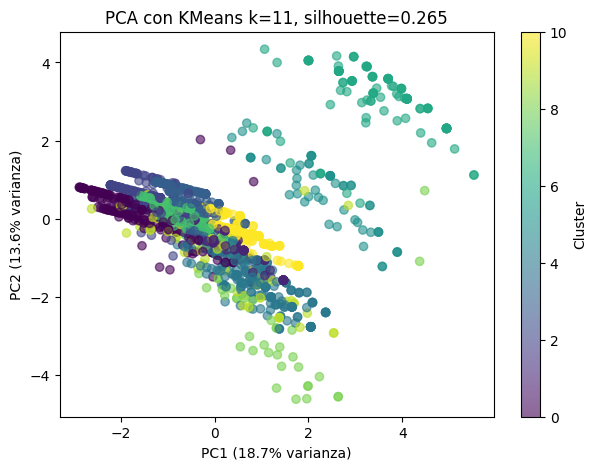

Medias de variables por cluster para k=11:


,multiplayer,cross_platform_multiplayer,steam_workshop,steam_trading_cards,in_app_purchases,valve_anti_cheat,cloud_gaming,stats,remote_play_on_phone,remote_play_on_tablet,platform,months_since_release
cluster,,,,,,,,,,,,
0,0.829444,2.841090,-0.378622,-0.446866,1.039630,-0.144129,-0.300725,-0.223275,-0.268554,-0.265317,-0.019583,-0.188013
1,0.829444,-0.351978,-0.441894,1.224168,0.005995,-0.144129,0.495398,-0.223275,-0.268554,-0.325000,-0.015614,0.457043
2,0.313083,-0.351978,-0.347694,-0.705182,1.727494,-0.144129,-0.514895,-0.223275,-0.268554,-0.325000,-0.355052,-0.381121
3,-1.205627,-0.351978,-0.351396,-0.687893,-0.578873,-0.144129,-0.523905,-0.223275,-0.268554,-0.325000,-0.278427,-0.777350
4,0.108278,-0.212475,2.262986,0.441436,-0.466914,-0.144129,0.321581,-0.223275,-0.268554,-0.325000,0.636077,0.424438
5,-0.515157,-0.294958,0.524135,0.458775,-0.249392,-0.144129,0.283350,-0.223275,-0.268554,3.076923,0.546110,0.883746
6,-0.318545,-0.270104,-0.349419,0.282145,-0.243760,-0.144129,-0.025677,-0.062521,3.723647,2.757084,0.250383,0.932117
7,0.829444,-0.351978,-0.441894,-0.816881,-0.578873,-0.144129,0.026088,-0.223275,-0.268554,-0.325000,-0.255021,-0.420990
8,0.829444,0.268897,0.835411,0.260339,-0.066347,6.938219,0.235619,0.299176,-0.046765,-0.136004,0.786851,0.946850


k=12, silhouette=0.263


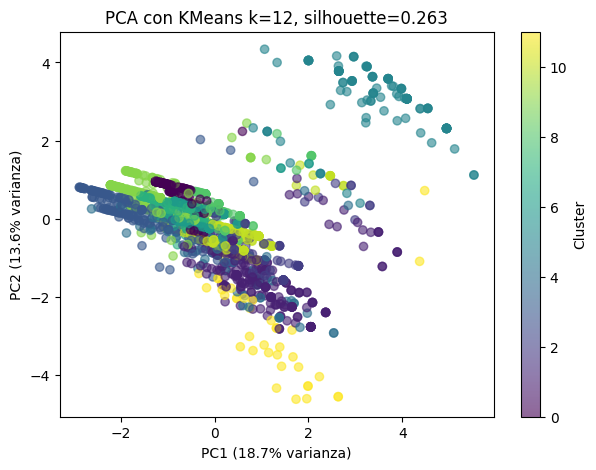

Medias de variables por cluster para k=12:


,multiplayer,cross_platform_multiplayer,steam_workshop,steam_trading_cards,in_app_purchases,valve_anti_cheat,cloud_gaming,stats,remote_play_on_phone,remote_play_on_tablet,platform,months_since_release
cluster,,,,,,,,,,,,
0,-1.205627,-0.351978,-0.282783,-0.612776,-0.578873,-0.144129,-0.933787,-0.223275,-0.268554,-0.304989,-0.345656,-1.132938
1,0.048122,-0.223685,2.262986,0.449663,-0.475911,-0.144129,0.319148,-0.223275,-0.268554,-0.021257,0.691943,0.477615
2,-0.148188,-0.289368,-0.441894,0.643870,-0.284925,-0.144129,0.245446,-0.223275,-0.268554,-0.058183,2.157876,0.601433
3,0.829444,2.841090,-0.378250,-0.456696,1.049150,-0.144129,-0.308794,-0.223275,-0.268554,-0.264966,-0.032715,-0.194951
4,-0.054205,-0.183921,0.341098,0.257355,0.088759,-0.144129,0.042183,4.478786,-0.268554,-0.235476,-0.108277,-0.013755
5,-0.318545,-0.270104,-0.349419,0.282145,-0.243760,-0.144129,-0.025677,-0.062521,3.723647,2.757084,0.250383,0.932117
6,-0.075032,-0.351978,-0.441894,-0.816881,-0.578873,-0.144129,1.070908,-0.223275,-0.268554,-0.256274,-0.469380,-0.383422
7,0.829444,-0.351978,-0.420427,-0.687291,-0.578873,-0.144129,-0.933787,-0.223275,-0.268554,-0.325000,-0.268706,-0.503112
8,-0.701064,-0.351978,-0.441894,0.549441,-0.521691,-0.144129,-0.933787,-0.223275,-0.268554,-0.156310,-0.425241,0.704723


k=13, silhouette=0.271


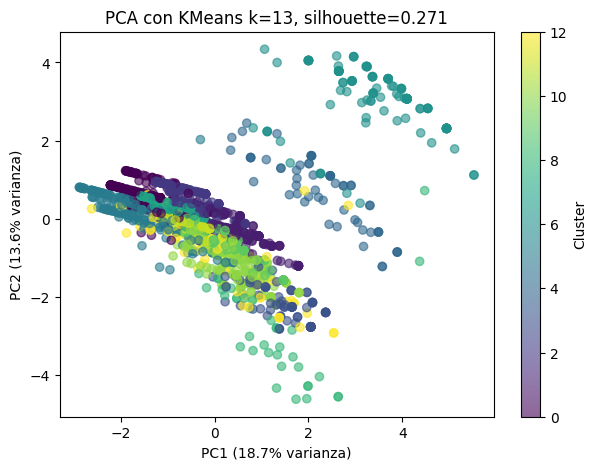

Medias de variables por cluster para k=13:


,multiplayer,cross_platform_multiplayer,steam_workshop,steam_trading_cards,in_app_purchases,valve_anti_cheat,cloud_gaming,stats,remote_play_on_phone,remote_play_on_tablet,platform,months_since_release
cluster,,,,,,,,,,,,
0,0.328503,-0.351978,-0.400280,-0.722679,1.727494,-0.144129,-0.502006,-0.223275,-0.268554,-0.325000,-0.347909,-0.414738
1,-1.205627,-0.351978,-0.441894,0.880412,-0.493902,-0.144129,0.469500,-0.223275,-0.268554,-0.325000,0.016986,0.231402
2,-1.205627,-0.351978,-0.441894,-0.685450,-0.578873,-0.144129,-0.485768,-0.223275,-0.268554,-0.325000,-0.276114,-0.759256
3,0.315085,-0.001091,2.262986,0.753157,-0.426805,-0.144129,0.167694,-0.223275,-0.268554,-0.325000,1.894829,0.741150
4,-0.468791,-0.186819,0.490823,0.449977,-0.220989,-0.144129,0.275943,-0.223275,-0.268554,3.076923,0.507029,0.887461
5,0.829444,2.841090,-0.393593,-0.452408,1.054803,-0.144129,-0.301353,-0.223275,-0.268554,-0.304750,-0.020558,-0.209075
6,-0.318545,-0.270104,-0.349419,0.282145,-0.243760,-0.144129,-0.025677,-0.062521,3.723647,2.757084,0.250383,0.932117
7,0.829444,-0.351978,-0.441894,-0.677719,-0.578873,-0.144129,-0.933787,-0.223275,-0.268554,-0.325000,-0.141770,-0.457011
8,0.829444,0.268897,0.835411,0.260339,-0.066347,6.938219,0.235619,0.299176,-0.046765,-0.136004,0.786851,0.946850


k=14, silhouette=0.286


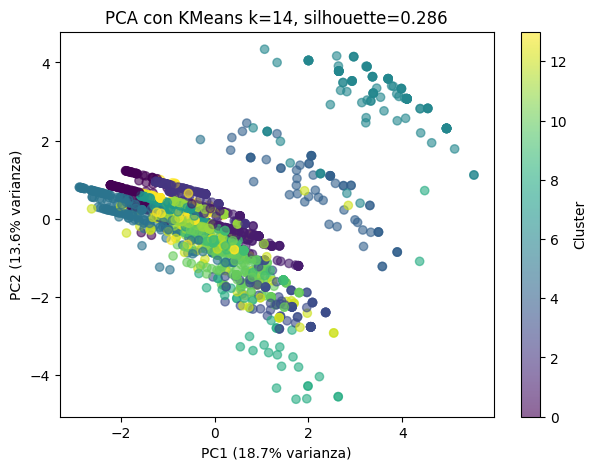

Medias de variables por cluster para k=14:


,multiplayer,cross_platform_multiplayer,steam_workshop,steam_trading_cards,in_app_purchases,valve_anti_cheat,cloud_gaming,stats,remote_play_on_phone,remote_play_on_tablet,platform,months_since_release
cluster,,,,,,,,,,,,
0,0.240787,-0.351978,-0.374831,-0.732540,1.727494,-0.144129,-0.668703,-0.223275,-0.268554,-0.325000,-0.394387,-1.067233
1,-1.205627,-0.351978,-0.441894,1.224168,-0.551740,-0.144129,0.257238,-0.223275,-0.268554,-0.325000,-0.005264,-0.068324
2,-1.205627,-0.351978,-0.441894,-0.816881,-0.578873,-0.144129,-0.933787,-0.223275,-0.268554,-0.325000,-0.239707,-0.633415
3,0.336742,-0.015865,2.092152,0.772989,-0.433208,-0.144129,0.079112,-0.223275,-0.268554,-0.325000,1.947515,0.751690
4,-0.468791,-0.186819,0.490823,0.449977,-0.220989,-0.144129,0.275943,-0.223275,-0.268554,3.076923,0.507029,0.887461
5,0.829444,2.841090,-0.393593,-0.452408,1.054803,-0.144129,-0.301353,-0.223275,-0.268554,-0.304750,-0.020558,-0.209075
6,-0.318545,-0.270104,-0.349419,0.282145,-0.243760,-0.144129,-0.025677,-0.062521,3.723647,2.757084,0.250383,0.932117
7,0.829444,-0.351978,-0.441894,-0.677719,-0.578873,-0.144129,-0.933787,-0.223275,-0.268554,-0.325000,-0.141770,-0.457011
8,0.829444,0.268897,0.835411,0.260339,-0.066347,6.938219,0.235619,0.299176,-0.046765,-0.136004,0.786851,0.946850


k=15, silhouette=0.280


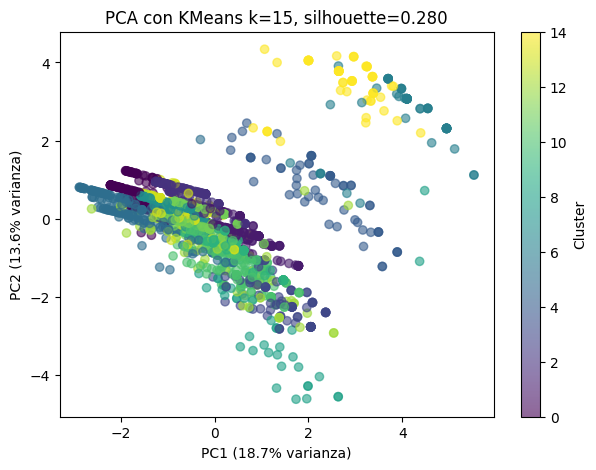

Medias de variables por cluster para k=15:


,multiplayer,cross_platform_multiplayer,steam_workshop,steam_trading_cards,in_app_purchases,valve_anti_cheat,cloud_gaming,stats,remote_play_on_phone,remote_play_on_tablet,platform,months_since_release
cluster,,,,,,,,,,,,
0,0.240787,-0.351978,-0.374831,-0.732540,1.727494,-0.144129,-0.668703,-0.223275,-0.268554,-0.325000,-0.394387,-1.067233
1,-1.205627,-0.351978,-0.441894,1.224168,-0.551740,-0.144129,0.257238,-0.223275,-0.268554,-0.325000,-0.005264,-0.068324
2,-1.205627,-0.351978,-0.441894,-0.816881,-0.578873,-0.144129,-0.933787,-0.223275,-0.268554,-0.325000,-0.239707,-0.633415
3,0.336742,-0.015865,2.092152,0.772989,-0.433208,-0.144129,0.079112,-0.223275,-0.268554,-0.325000,1.947515,0.751690
4,-0.468791,-0.186819,0.490823,0.449977,-0.220989,-0.144129,0.275943,-0.223275,-0.268554,3.076923,0.507029,0.887461
5,0.829444,2.841090,-0.393593,-0.452408,1.054803,-0.144129,-0.301353,-0.223275,-0.268554,-0.304750,-0.020558,-0.209075
6,-0.889840,-0.296925,-0.348622,1.188978,-0.380049,-0.144129,0.483325,-0.061135,3.723647,2.725000,0.571397,0.929330
7,0.829444,-0.351978,-0.441894,-0.677719,-0.578873,-0.144129,-0.933787,-0.223275,-0.268554,-0.325000,-0.141770,-0.457011
8,0.829444,0.268897,0.835411,0.260339,-0.066347,6.938219,0.235619,0.299176,-0.046765,-0.136004,0.786851,0.946850


k=16, silhouette=0.297


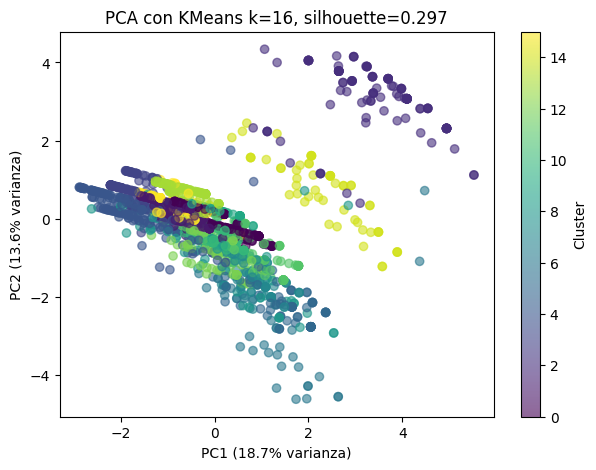

Medias de variables por cluster para k=16:


,multiplayer,cross_platform_multiplayer,steam_workshop,steam_trading_cards,in_app_purchases,valve_anti_cheat,cloud_gaming,stats,remote_play_on_phone,remote_play_on_tablet,platform,months_since_release
cluster,,,,,,,,,,,,
0,-1.205627,-0.351978,-0.441894,0.179345,-0.565145,-0.144129,1.070908,-0.223275,-0.268554,-0.325000,-0.409447,-0.260388
1,0.829444,-0.351978,-0.441894,-0.816881,-0.578873,-0.144129,0.050336,-0.223275,-0.268554,-0.325000,-0.426013,-0.465406
2,-0.318545,-0.270104,-0.349419,0.282145,-0.243760,-0.144129,-0.025677,-0.062521,3.723647,2.757084,0.250383,0.932117
3,0.232958,-0.351978,-0.418576,-0.746500,1.727494,-0.144129,-0.674559,-0.223275,-0.268554,-0.325000,-0.386075,-1.082518
4,0.829444,2.841090,-0.393011,-0.484903,1.088380,-0.144129,-0.293733,-0.223275,-0.268554,-0.263519,-0.081200,-0.223540
5,0.288476,0.011790,2.262986,0.707447,-0.462095,-0.144129,0.258880,-0.223275,-0.268554,-0.325000,2.106449,0.732159
6,0.829444,0.268897,0.835411,0.260339,-0.066347,6.938219,0.235619,0.299176,-0.046765,-0.136004,0.786851,0.946850
7,-0.008527,-0.305021,2.262986,1.224168,-0.375370,-0.144129,0.274926,-0.223275,-0.268554,-0.325000,-0.244087,0.209816
8,-0.054205,-0.183921,0.341098,0.257355,0.088759,-0.144129,0.042183,4.478786,-0.268554,-0.235476,-0.108277,-0.013755


k=17, silhouette=0.313


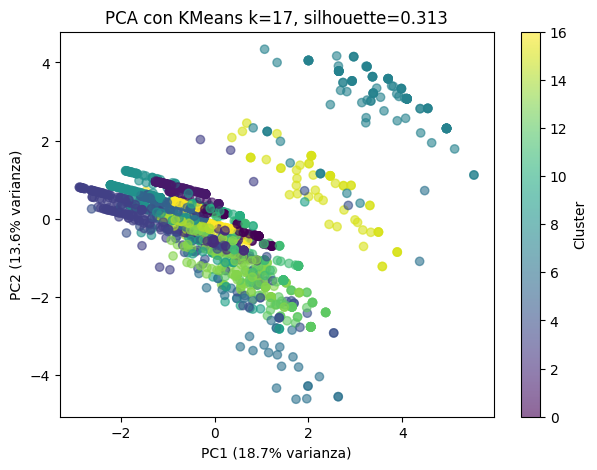

Medias de variables por cluster para k=17:


,multiplayer,cross_platform_multiplayer,steam_workshop,steam_trading_cards,in_app_purchases,valve_anti_cheat,cloud_gaming,stats,remote_play_on_phone,remote_play_on_tablet,platform,months_since_release
cluster,,,,,,,,,,,,
0,-1.205627,-0.351978,-0.441894,0.203643,-0.487833,-0.144129,1.070908,-0.223275,-0.268554,-0.325000,-0.353892,0.752026
1,-1.205627,-0.351978,-0.441894,-0.816881,-0.578873,-0.144129,-0.933787,-0.223275,-0.268554,-0.325000,-0.334554,-0.682319
2,0.829444,-0.351978,-0.441894,1.224168,-0.036199,-0.144129,0.690933,-0.223275,-0.268554,-0.325000,-0.446920,0.428134
3,0.829444,2.841090,-0.387433,-0.542915,1.263124,-0.144129,-0.341796,-0.223275,-0.268554,-0.256505,-0.211386,-0.319790
4,-0.054205,-0.183921,0.341098,0.257355,0.088759,-0.144129,0.042183,4.478786,-0.268554,-0.235476,-0.108277,-0.013755
5,0.829444,-0.351978,-0.441894,-0.816881,-0.578873,-0.144129,-0.933787,-0.223275,-0.268554,-0.325000,-0.273432,-0.459966
6,0.829444,0.268897,0.835411,0.260339,-0.066347,6.938219,0.235619,0.299176,-0.046765,-0.136004,0.786851,0.946850
7,-0.318545,-0.270104,-0.349419,0.282145,-0.243760,-0.144129,-0.025677,-0.062521,3.723647,2.757084,0.250383,0.932117
8,0.397762,-0.351978,-0.414572,-0.610715,1.727494,-0.144129,-0.549047,-0.223275,-0.268554,-0.325000,-0.426956,-0.356067


k=18, silhouette=0.293


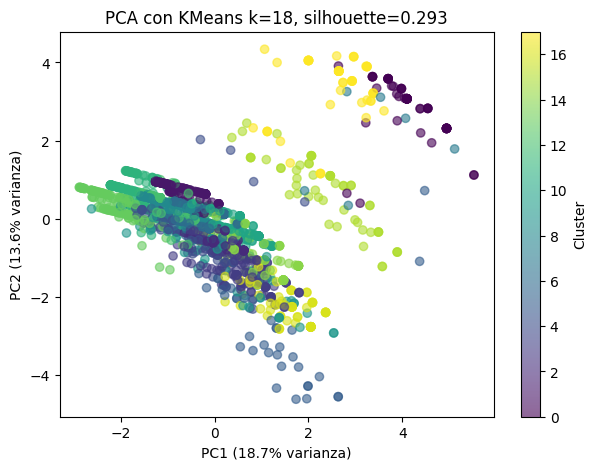

Medias de variables por cluster para k=18:


,multiplayer,cross_platform_multiplayer,steam_workshop,steam_trading_cards,in_app_purchases,valve_anti_cheat,cloud_gaming,stats,remote_play_on_phone,remote_play_on_tablet,platform,months_since_release
cluster,,,,,,,,,,,,
0,-1.033163,-0.297858,-0.304358,0.878228,-0.539782,-0.144129,0.425329,-0.223275,3.723647,2.961604,0.694132,0.928909
1,-1.205627,-0.351978,-0.441894,-0.816881,-0.578873,-0.144129,-0.933787,-0.223275,-0.268554,-0.325000,-0.334554,-0.682319
2,0.829444,-0.351978,-0.441894,1.224168,-0.039723,-0.144129,0.680383,-0.223275,-0.268554,-0.325000,-0.447831,0.422312
3,-0.059958,-0.351978,2.262986,0.180965,-0.476368,-0.144129,0.283880,-0.223275,-0.268554,-0.325000,-0.310682,0.153122
4,0.829444,2.841090,-0.264525,-0.047305,0.517596,-0.144129,-0.407965,-0.223275,-0.268554,-0.101923,0.835727,0.763045
5,0.829444,0.268897,0.835411,0.260339,-0.066347,6.938219,0.235619,0.299176,-0.046765,-0.136004,0.786851,0.946850
6,-0.072701,-0.351978,-0.441894,-0.816881,-0.578873,-0.144129,1.070908,-0.223275,-0.268554,-0.325000,-0.476572,-0.411771
7,-0.527270,-0.351978,-0.441894,0.543818,-0.194479,-0.144129,0.068561,4.478786,2.392913,3.076923,0.501665,0.963926
8,0.829444,-0.351978,-0.441894,-0.700724,-0.578873,-0.144129,-0.933787,-0.223275,-0.268554,-0.325000,-0.283702,-0.496790


k=19, silhouette=0.310


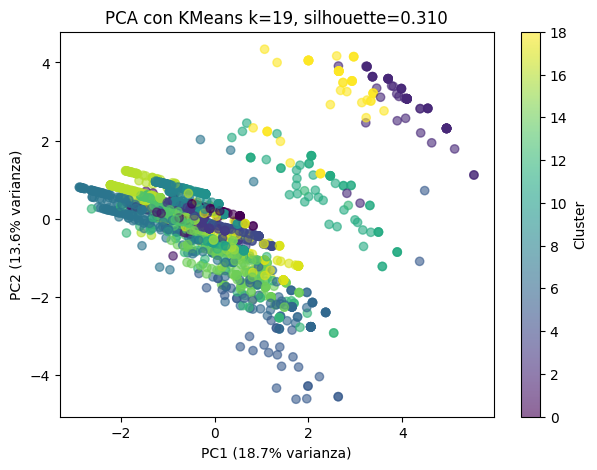

Medias de variables por cluster para k=19:


,multiplayer,cross_platform_multiplayer,steam_workshop,steam_trading_cards,in_app_purchases,valve_anti_cheat,cloud_gaming,stats,remote_play_on_phone,remote_play_on_tablet,platform,months_since_release
cluster,,,,,,,,,,,,
0,-0.969677,-0.351978,-0.441894,1.224168,-0.578873,-0.144129,-0.933787,-0.223275,-0.268554,-0.325000,-0.465486,-0.246910
1,0.585235,-0.351978,-0.387796,-0.490313,1.727494,-0.144129,1.070908,-0.223275,-0.268554,-0.325000,-0.531225,-0.161497
2,-1.053756,-0.304320,-0.320780,0.736753,-0.510027,-0.144129,0.322888,-0.012735,3.723647,2.975373,0.694368,0.935665
3,0.829444,-0.351978,-0.441894,-0.242217,-0.578873,-0.144129,-0.369358,-0.223275,-0.268554,-0.325000,-0.396934,0.773805
4,-1.205627,-0.351978,-0.441894,1.224168,-0.550747,-0.144129,1.070908,-0.223275,-0.268554,-0.325000,-0.370965,-0.186686
5,0.829444,0.268897,0.835411,0.260339,-0.066347,6.938219,0.235619,0.299176,-0.046765,-0.136004,0.786851,0.946850
6,0.276709,0.042228,2.262986,0.720205,-0.436505,-0.144129,0.254181,-0.223275,-0.268554,-0.325000,2.074506,0.716189
7,0.829444,2.841090,-0.393878,-0.454565,1.058784,-0.144129,-0.305095,-0.223275,-0.268554,-0.264611,-0.040479,-0.201971
8,-1.205627,-0.351978,-0.441894,-0.816881,-0.578873,-0.144129,-0.438509,-0.223275,-0.268554,-0.325000,-0.373107,-1.240906


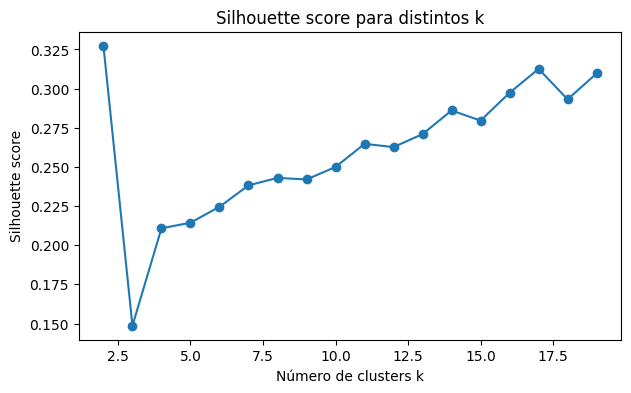

In [22]:
# --- Definir k para probar ---
k_values = list(range(2, 20)) # k pequeños y algunos grandes
sil_scores = []

for k in k_values:
    km = KMeans(n_clusters=k, random_state=42, n_init=10)
    labels = km.fit_predict(X_scaled)
    
    # Silhouette score
    sil = silhouette_score(X_scaled, labels)
    sil_scores.append(sil)
    print(f"k={k}, silhouette={sil:.3f}")
    
    # Scatter PCA con clusters coloreados
    plt.figure(figsize=(7,5))
    plt.scatter(X_pca[:,0], X_pca[:,1], c=labels, cmap='viridis', alpha=0.6)
    plt.xlabel(f"PC1 ({pca.explained_variance_ratio_[0]*100:.1f}% varianza)")
    plt.ylabel(f"PC2 ({pca.explained_variance_ratio_[1]*100:.1f}% varianza)")
    plt.title(f"PCA con KMeans k={k}, silhouette={sil:.3f}")
    plt.colorbar(label="Cluster")
    plt.show()
    
    # Medias de variables por cluster
    df_scaled = pd.DataFrame(X_scaled, columns=df_unsup.columns)
    df_scaled['cluster'] = labels
    print(f"Medias de variables por cluster para k={k}:")
    display(df_scaled.groupby('cluster').mean())

# --- Gráfico resumen de silhouette ---
plt.figure(figsize=(7,4))
plt.plot(k_values, sil_scores, marker='o')
plt.xlabel("Número de clusters k")
plt.ylabel("Silhouette score")
plt.title("Silhouette score para distintos k")
plt.show()

En el dataset, la silhouette media alcanzó un máximo para k = 2 (~0.32), descendió notablemente para valores intermedios de k (~10) y mostró una recuperación parcial para k elevados (~0.28 para k = 14). Este comportamiento confirma que los clústers adicionales con k grandes representan una subdivisión artificial del espacio y no una estructura natural. Por criterios de estabilidad, interpretabilidad y prevención del sobreajuste, se ha seleccionado k = 2 como la solución más adecuada para caracterizar los principales perfiles de videojuegos en el dataset.

### Clustering con K-Means
#### 8.1 Model final

Con esta decisión de usar dos clusters, se prepara el modelo final, fijando k = 2. Una vez ajustado el modelo, a cada videojuego se le asinga una etiqueta de clúser en función a su proximidad al centroide correspondiente. Así, se pueden interpretar mejor los datos en posteriores gráficas.


In [24]:
kmeans = KMeans(n_clusters=2, random_state=42, n_init=10)
clusters = kmeans.fit_predict(X_scaled)

df_unsup["cluster"] = clusters
df_unsup.head()

,multiplayer,cross_platform_multiplayer,steam_workshop,steam_trading_cards,in_app_purchases,valve_anti_cheat,cloud_gaming,stats,remote_play_on_phone,remote_play_on_tablet,platform,months_since_release,cluster
0,1,1,1,1,1,1,1,1,1,1,3,60.0,0
1,1,0,1,1,1,1,1,0,0,0,4,60.0,1
2,1,0,0,0,0,0,0,1,1,1,1,60.0,0
3,1,1,0,0,1,0,1,0,0,0,1,1.0,1
4,0,0,1,1,0,0,1,0,0,0,2,1.0,1


8.2 Visualización de clusters en PCA

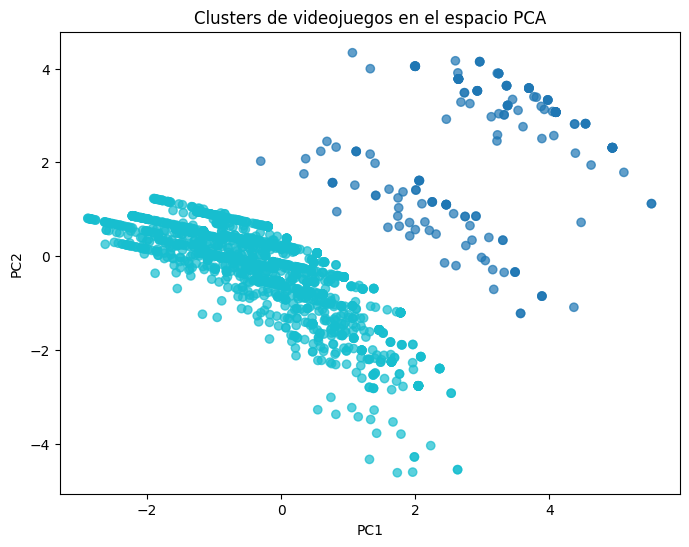

In [25]:
plt.figure(figsize=(8,6))
plt.scatter(
    X_pca[:, 0],
    X_pca[:, 1],
    c=clusters,
    cmap="tab10",
    alpha=0.7
)
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.title("Clusters de videojuegos en el espacio PCA")
plt.show()

En el PCA se puede apreciar que lo que parecía una división clara en tres clúster, se ha convertido en dos únicamente.

### 9. Interpretación de cada cluster
#### 9.1 Perfil medio de cada cluster

En la siguiente tabla se puede apreciar la relación de cada variable con cada clúster en detalle.

In [38]:
cluster_summary = df_unsup.groupby("cluster").mean()
cluster_summary

,multiplayer,cross_platform_multiplayer,steam_workshop,steam_trading_cards,in_app_purchases,valve_anti_cheat,cloud_gaming,stats,remote_play_on_phone,remote_play_on_tablet,platform,months_since_release,high_rating
cluster,,,,,,,,,,,,,
0,0.422222,0.044444,0.138889,0.566667,0.155556,0.011111,0.505556,0.038889,0.661111,0.938889,1.994444,58.321296,0.861111
1,0.611705,0.117684,0.166142,0.381372,0.261800,0.021397,0.461296,0.048458,0.000000,0.000000,1.587791,34.812314,0.667086


### 10. Relación con la valoración del videojuego
En la siguiente gráfica se puede apreciar la diferencia de valoración media entre clústers.

In [28]:
df_unsup["high_rating"] = df_games.loc[df_unsup.index, "positive_reviews_per"] > 80
df_unsup.groupby("cluster")["high_rating"].mean()

cluster
0    0.861111
1    0.667086
Name: high_rating, dtype: float64

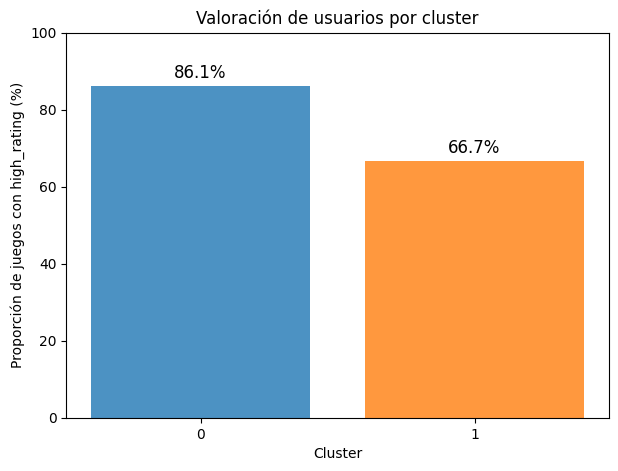

In [32]:
# Calcular proporción de high_rating por cluster
high_rating_perc = df_unsup.groupby("cluster")["high_rating"].mean() * 100

# Gráfico de barras
plt.figure(figsize=(7,5))
bars = plt.bar(
    high_rating_perc.index.astype(str),
    high_rating_perc.values,
    color=["#1f77b4", "#ff7f0e"],
    alpha=0.8
)

# Etiquetas de porcentaje encima de cada barra
for bar in bars:
    height = bar.get_height()
    plt.text(
        bar.get_x() + bar.get_width()/2,
        height + 1,
        f"{height:.1f}%",
        ha='center',
        va='bottom',
        fontsize=12
    )

plt.xlabel("Cluster")
plt.ylabel("Proporción de juegos con high_rating (%)")
plt.title("Valoración de usuarios por cluster")
plt.ylim(0, 100)
plt.show()

A pesar de no ser enorme, se puede visualizar una preferencia por los videojuegos del clúster 1.

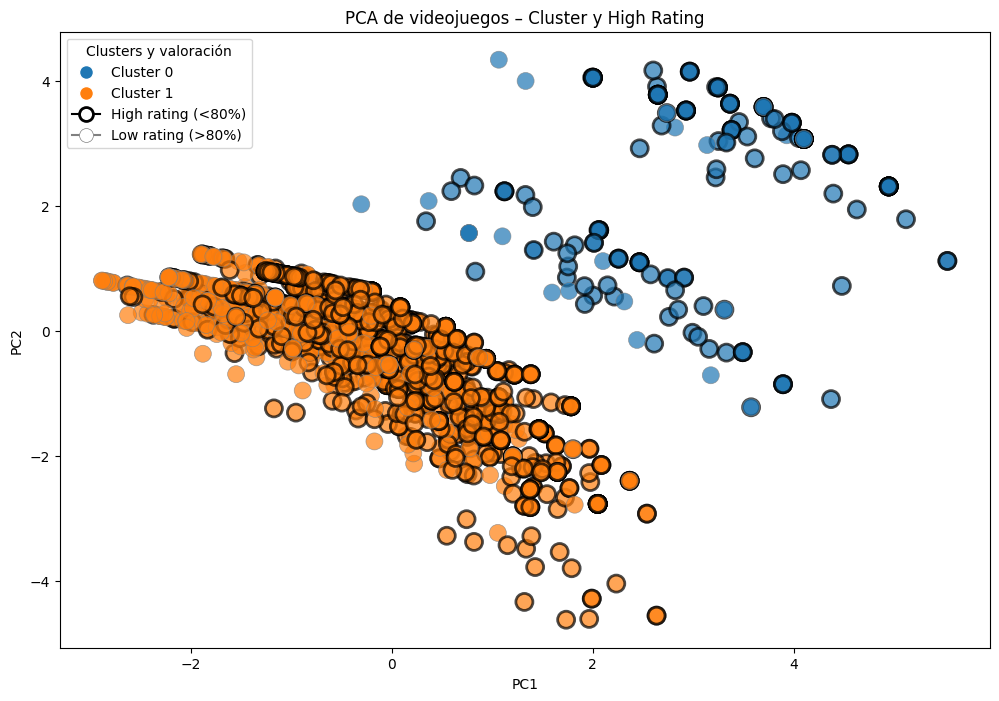

In [34]:
plt.figure(figsize=(12,8))

# Colores por cluster
cluster_colors = ["#1f77b4", "#ff7f0e"]

for i, color in enumerate(cluster_colors):
    idx = df_unsup["cluster"] == i
    # Borde según high_rating
    edge_colors = df_unsup.loc[idx, "high_rating"].map({True: 'black', False: 'gray'})
    linewidths = df_unsup.loc[idx, "high_rating"].map({True: 2, False: 0.5})
    
    plt.scatter(
        X_pca[idx, 0],
        X_pca[idx, 1],
        c=color,
        s=150,  # tamaño fijo
        alpha=0.7,
        edgecolor=edge_colors,
        linewidths=linewidths,
        label=f"Cluster {i}"
    )

plt.xlabel("PC1")
plt.ylabel("PC2")
plt.title("PCA de videojuegos – Cluster y High Rating")

# Crear leyenda personalizada
legend_elements = [
    Line2D([0], [0], marker='o', color='w', label='Cluster 0',
           markerfacecolor=cluster_colors[0], markersize=10),
    Line2D([0], [0], marker='o', color='w', label='Cluster 1',
           markerfacecolor=cluster_colors[1], markersize=10),
    Line2D([0], [0], marker='o', color='black', label='High rating (<80%)',
           markerfacecolor='white', markersize=10, markeredgewidth=2),
    Line2D([0], [0], marker='o', color='gray', label='Low rating (>80%)',
           markerfacecolor='white', markersize=10, markeredgewidth=0.5)
]

plt.legend(handles=legend_elements, title="Clusters y valoración")
plt.show()


Finalmente, en este gráfico se puede observar que a pesar de que la mayoría de datos están por encima del 80% de reseñas positivas, tenemos un porcentaje ligeramente mayor en el clúster 0. Ahora, vamos a ver qué tipo de videojuegos son, qué variables definen a cada clúster.

,multiplayer,cross_platform_multiplayer,steam_workshop,steam_trading_cards,in_app_purchases,valve_anti_cheat,cloud_gaming,stats,remote_play_on_phone,remote_play_on_tablet,platform,months_since_release
0,-0.346375,-0.210063,-0.066216,0.339713,-0.220105,-0.065436,0.079698,-0.040417,2.370734,2.869028,0.340924,0.918458
1,0.039237,0.023796,0.007501,-0.038482,0.024933,0.007413,-0.009028,0.004578,-0.268554,-0.325000,-0.038619,-0.104042


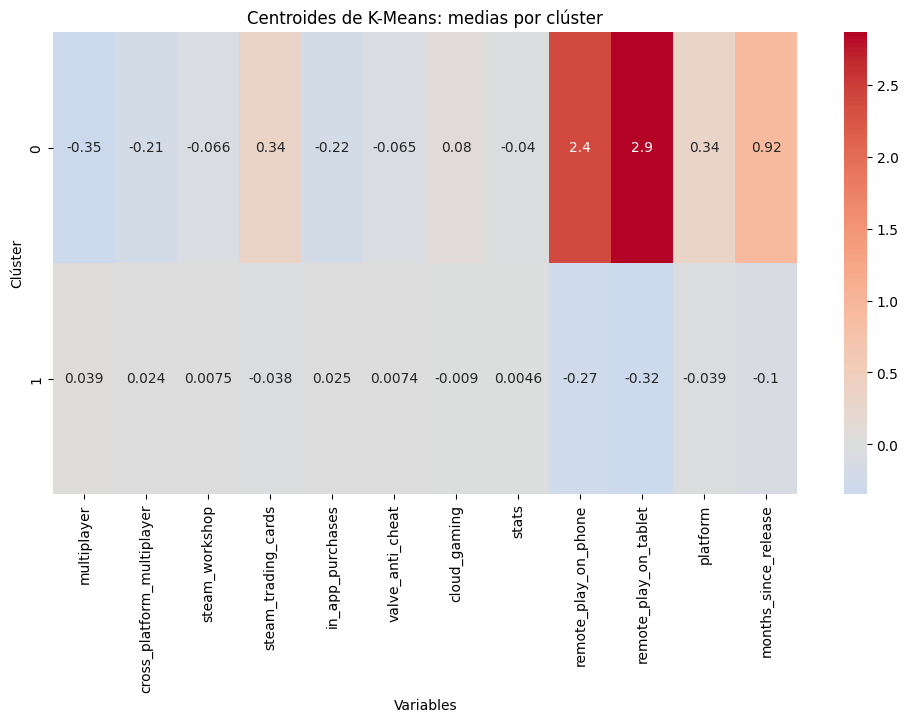

In [44]:
# --- Seleccionar solo las columnas usadas para K-Means ---
df_unsup_features = df_unsup.drop(columns=['cluster', 'high_rating'], errors='ignore')

# --- Obtener centroides ---
centroids = pd.DataFrame(kmeans.cluster_centers_, columns=df_unsup_features.columns)

# Mostrar centroides
display(centroids)

# --- Visualizar con heatmap ---
plt.figure(figsize=(12,6))
sns.heatmap(centroids, annot=True, cmap="coolwarm", center=0)
plt.title("Centroides de K-Means: medias por clúster")
plt.xlabel("Variables")
plt.ylabel("Clúster")
plt.show()

Todo apunta a que la opción de jugar por remoto es lo que más define al clúster 0, que más reseñas positivas tiene en porcentaje